### First attempt at building a Neural Network to learn a non-linear F(s)


In [1]:
import torch
import numpy as np
import pandas as pd
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn import preprocessing, metrics
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim
import time
import seaborn as sns
import matplotlib.pyplot as plt


print(torch.__version__)

1.9.0


# Data Preprocessing

In [2]:
df_geometric = pd.read_csv('../bricks_data/dataset_geometric.csv')
df_kitanidis = pd.read_csv('../bricks_data/dataset_kitanidis.csv')
df_kitanidis.drop('pixel_id', axis=1, inplace=True)
df_geometric.drop('pixel_id', axis=1, inplace=True)

train_df_geo, test_df_geo = train_test_split(df_geometric, test_size=0.33, random_state=44, shuffle=True)
train_df_kit, test_df_kit = train_test_split(df_kitanidis, test_size=0.33, random_state=44, shuffle=True)

In [3]:
train_df_kit.head()

,lrg,elg,qso,stellar,EBV,airmass,fwhm,ccdskysb_g,ccdskysb_r,ccdskysb_z,exptime_g,exptime_r,exptime_z,meansky_g,meansky_r,meansky_z,galdepth_g,galdepth_r,galdepth_z
89136,33,108,135,14,0.018107,1.319964,3.886310,23.432305,22.669881,20.389898,103.560000,45.820000,79.306667,1.315610e-01,2.650449e-01,2.247409e+00,23.790844,23.136869,22.230731
161006,35,124,147,20,0.027707,1.291452,4.266571,23.534226,22.664447,20.069928,90.000000,90.000000,90.000000,2.144951e+08,6.823467e+08,2.257909e+09,23.459292,23.163053,22.008386
86817,26,82,116,15,0.147090,1.324597,5.368878,23.549151,22.722929,20.304141,188.973333,81.126667,160.739333,1.058678e-01,2.296210e-01,2.123827e+00,24.115970,23.479475,22.420954
116131,11,73,71,7,0.022910,1.476976,4.209666,23.492786,22.685325,20.136689,121.533333,53.413333,128.116667,1.165547e-01,2.448748e-01,2.796967e+00,23.913834,23.310549,22.329167
34538,12,59,68,8,0.010726,1.667206,4.654831,23.515421,22.689333,19.506456,149.774994,96.747853,140.954691,1.897221e-01,4.977593e-01,3.323957e+00,23.723508,22.956473,22.234153


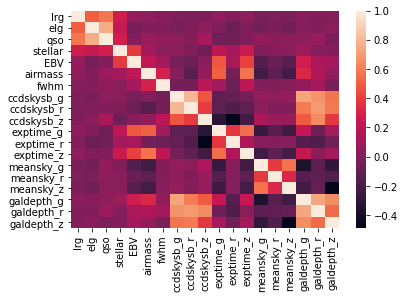

In [4]:
corrMatrix = df_kitanidis.corr()
sns.heatmap(corrMatrix, annot=False)
plt.show()


# Neural Network

### Defining The Dataset Class Inheriting from Torch.dataset to be able to use a dataloader for training

In [5]:
class DensitySurvey(Dataset):
    def __init__(self, df, galaxy_type, scaler_in=None, scaler_out=None):
        self.data = df
        # Extracting Targets and Input
        self.target = self.data[galaxy_type].to_numpy(copy=True)
        self.input = self.data.drop(columns=['lrg','elg','qso']).to_numpy(copy=True)

        # Scaling, when scaler is passed (test-set) use the existing scaler
        self.scaler_in = scaler_in
        self.scaler_out = scaler_out
        if self.scaler_in is None:
            self.scaler_in = preprocessing.MinMaxScaler()
            self.scaler_out = preprocessing.MinMaxScaler()
            self.input = self.scaler_in.fit_transform(self.input)
            self.target = self.scaler_out.fit_transform(self.target.reshape(-1, 1))
        else:
            self.input = self.scaler_in.transform(self.input)
            self.target = self.scaler_out.transform(self.target.reshape(-1, 1))


    def __len__(self):
        return len(self.target)

    def __getitem__(self, idx):
        return torch.from_numpy(self.input[idx]).float(), torch.tensor(self.target[idx]).float()

    def __getscaler__(self):
        return self.scaler_in, self.scaler_out






### Define Models and Hyperparameters



In [ ]:
class LinearRegression(nn.Module):
    def __init__(self, n_input_vars = 17, n_output_vars=1):
        super().__init__() # call constructor of superclass
        self.linear = nn.Linear(n_input_vars, n_output_vars)

    def forward(self, x):
        return self.linear(x)


device = 'cpu'
model = LinearRegression().to(device)



In [6]:
class Net(nn.Module):
    def __init__(self, n_feature = 16, n_hidden = 10, n_output = 1):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(n_feature,n_hidden)
        #self.fc2 = nn.Linear(n_hidden,n_hidden)
        self.predict = nn.Linear(n_hidden,n_output)

    def forward(self,x):
        out = F.relu(self.fc1(x))
        out = self.predict(out)
        return out

device = 'cpu'




In [8]:
# Defining Loss
criterion = nn.MSELoss()

#Defining Hyperparemeters
no_epochs = 100 #very low, but computational power not sufficient for more iterations
batch = 1024
learning_rate = 0.001

#Using the Adam Method for Stochastic Optimisation
#optimiser = optim.Adam(model.parameters(), lr=learning_rate)

galaxy_types = ['LRG', 'ELG', 'QSO']

### Kitanidis

In [9]:
for gal in galaxy_types:

    model = Net().to(device)
    optimiser = optim.Adam(model.parameters(), lr=learning_rate)


    print("GALAXY TYPE: ", gal)
    print()
    traindata = DensitySurvey(train_df_kit, gal)
    scaler_in, scaler_out = traindata.__getscaler__()
    testdata = DensitySurvey(test_df_kit, gal, scaler_in, scaler_out)

    time_start = time.time()

    for epoch in range(no_epochs):
        loss_per_epoch = 0

        #loading the training data from trainset and shuffling for each epoch
        trainloader = torch.utils.data.DataLoader(traindata, batch_size=batch, shuffle = True)

        for i, batch_no in enumerate(trainloader, 0):

            #Put Model into train mode
            model.train()

            #Extract inputs and associated labels from dataloader batch
            inputs = batch_no[0].to(device)
            labels = batch_no[1].to(device)

            #Zero-out the gradients before backward pass (pytorch stores the gradients)
            optimiser.zero_grad()

            #Predict outputs (forward pass)
            predictions =  model(inputs)

            #Compute Loss
            loss = criterion(predictions, labels)

            #Backpropagation
            loss.backward()

            #Perform one step of gradient descent
            optimiser.step()

            #Append loss to the general loss for this one epoch
            loss_per_epoch += loss.item()
        if epoch % 10 == 0:
            print("Loss for Epoch", epoch, ": ", loss_per_epoch)

    time_end = time.time()
    time_passed = time_end - time_start
    print()
    print(f"{time_passed/60:.5} minutes ({time_passed:.3} seconds) taken to train the model")


    model.eval()
    y_pred = np.array([])
    testloader = torch.utils.data.DataLoader(testdata, batch_size=batch, shuffle=False)


    for batch_no in testloader:

        #Split dataloader
        inputs = batch_no[0].to(device)
        labels = batch_no[1].to(device)

        #Forward pass through the trained network
        outputs = model(inputs)

        #Get predictions and append to label array + count number of correct and total
        y_pred = np.append(y_pred, outputs.detach().numpy())

    y_gold = testdata.target



    print(f"Neural Net R^2 for {gal}, Kitanidis :  {metrics.r2_score(y_gold, y_pred)}.")
    print(f"Neural Net MSE for {gal}, Kitanidis :  {metrics.mean_squared_error(y_gold, y_pred)}.")


GALAXY TYPE:  LRG

Loss for Epoch 0 :  0.055659619509242475
Loss for Epoch 10 :  0.047092226159293205
Loss for Epoch 20 :  0.046443431347142905
Loss for Epoch 30 :  0.046371587639441714
Loss for Epoch 40 :  0.04637736457516439
Loss for Epoch 50 :  0.04607162805041298
Loss for Epoch 60 :  0.0463370299548842
Loss for Epoch 70 :  0.04623115135473199
Loss for Epoch 80 :  0.046324527414981276
Loss for Epoch 90 :  0.046368653886020184

2.65 minutes (1.59e+02 seconds) taken to train the model
Neural Net R^2 for LRG, Kitanidis :  0.09512772957911253.
Neural Net MSE for LRG, Kitanidis :  0.0004425338169648956.
GALAXY TYPE:  ELG

Loss for Epoch 0 :  0.1746001905121375
Loss for Epoch 10 :  0.02544980352104176
Loss for Epoch 20 :  0.024404774885624647
Loss for Epoch 30 :  0.02381907326343935
Loss for Epoch 40 :  0.023172870351118036
Loss for Epoch 50 :  0.02286576878395863
Loss for Epoch 60 :  0.022516714758239686
Loss for Epoch 70 :  0.0221528021938866
Loss for Epoch 80 :  0.022071532090194523
Lo

### Geometric Neural Net

In [10]:
for gal in galaxy_types:
    model = Net().to(device)
    optimiser = optim.Adam(model.parameters(), lr=learning_rate)
    print("GALAXY TYPE: ", gal)
    print()
    traindata = DensitySurvey(train_df_geo, gal)
    scaler_in, scaler_out = traindata.__getscaler__()
    testdata = DensitySurvey(test_df_geo, gal, scaler_in, scaler_out)

    time_start = time.time()

    for epoch in range(no_epochs):
        loss_per_epoch = 0

        #loading the training data from trainset and shuffling for each epoch
        trainloader = torch.utils.data.DataLoader(traindata, batch_size=batch, shuffle = True)

        for i, batch_no in enumerate(trainloader, 0):

            #Put Model into train mode
            model.train()

            #Extract inputs and associated labels from dataloader batch
            inputs = batch_no[0].to(device)
            labels = batch_no[1].to(device)

            #Zero-out the gradients before backward pass (pytorch stores the gradients)
            optimiser.zero_grad()

            #Predict outputs (forward pass)
            predictions =  model(inputs)

            #Compute Loss
            loss = criterion(predictions, labels)

            #Backpropagation
            loss.backward()

            #Perform one step of gradient descent
            optimiser.step()

            #Append loss to the general loss for this one epoch
            loss_per_epoch += loss.item()
        if epoch % 10 == 0:
            print("Loss for Epoch", epoch, ": ", loss_per_epoch)

    time_end = time.time()
    time_passed = time_end - time_start
    print()
    print(f"{time_passed/60:.5} minutes ({time_passed:.3} seconds) taken to train the model")


    model.eval()
    y_pred = np.array([])
    testloader = torch.utils.data.DataLoader(testdata, batch_size=batch, shuffle=False)


    for batch_no in testloader:

        #Split dataloader
        inputs = batch_no[0].to(device)
        labels = batch_no[1].to(device)

        #Forward pass through the trained network
        outputs = model(inputs)

        #Get predictions and append to label array + count number of correct and total
        y_pred = np.append(y_pred, outputs.detach().numpy())

    y_gold = testdata.target


    print()
    print(f"Neural Net R^2 for {gal}, Geometric :  {metrics.r2_score(y_gold, y_pred)}.")
    print(f"Neural Net MSE for {gal}, Geometric :  {metrics.mean_squared_error(y_gold, y_pred)}.")

GALAXY TYPE:  LRG

Loss for Epoch 0 :  0.1162809282541275
Loss for Epoch 10 :  0.0645222504681442
Loss for Epoch 20 :  0.0625937175063882
Loss for Epoch 30 :  0.06243429446476512
Loss for Epoch 40 :  0.06230533667257987
Loss for Epoch 50 :  0.06227218222920783
Loss for Epoch 60 :  0.061999652738450095
Loss for Epoch 70 :  0.06181814146111719
Loss for Epoch 80 :  0.06085118683404289
Loss for Epoch 90 :  0.06059876336075831

4.1149 minutes (2.47e+02 seconds) taken to train the model

Neural Net R^2 for LRG, Geometric :  0.38443757500315257.
Neural Net MSE for LRG, Geometric :  0.0003322833752020372.
GALAXY TYPE:  ELG

Loss for Epoch 0 :  2.4312975874054246
Loss for Epoch 10 :  0.06502228003228083
Loss for Epoch 20 :  0.055561175948241726
Loss for Epoch 30 :  0.046266059929621406
Loss for Epoch 40 :  0.03645620016322937
Loss for Epoch 50 :  0.03533643936680164
Loss for Epoch 60 :  0.03508950311515946
Loss for Epoch 70 :  0.03495112086238805
Loss for Epoch 80 :  0.03485323264612816
Loss fo

# Regression

In [19]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import AdaBoostRegressor
galaxy_types = ['lrg','elg','qso']


### Geometrics

### Geometric - Linear Regression

In [14]:
for gal in galaxy_types:
    y_train = train_df_geo[gal]#.to_numpy(copy=True)
    X_train = train_df_geo.drop(columns=['lrg','elg','qso'])#.to_numpy(copy=True)
    y_gold = test_df_geo[gal]
    X_test = test_df_geo.drop(columns=['lrg','elg','qso'])
    reg = LinearRegression()
    reg.fit(X_train,y_train)
    y_pred = reg.predict(X_test)

    print(f"Linear Regression R^2 for {gal}, Geometric :  {metrics.r2_score(y_gold, y_pred)}.")
    print(f"Linear Regression MSE for {gal}, Geometric :  {metrics.mean_squared_error(y_gold, y_pred)}.")

Linear Regression R^2 for lrg, Geometric :  0.22429511761770937.
Linear Regression MSE for lrg, Geometric :  116.73494454968107.
Linear Regression R^2 for elg, Geometric :  0.2707214443169599.
Linear Regression MSE for elg, Geometric :  996.3742889230185.
Linear Regression R^2 for qso, Geometric :  0.2873594296697155.
Linear Regression MSE for qso, Geometric :  1806.4367916145238.


### Geometric - Ridge Regression

In [15]:
for gal in galaxy_types:
    y_train = train_df_geo[gal]#.to_numpy(copy=True)
    X_train = train_df_geo.drop(columns=['lrg','elg','qso'])#.to_numpy(copy=True)
    y_gold = test_df_geo[gal]
    X_test = test_df_geo.drop(columns=['lrg','elg','qso'])
    reg = Ridge()
    reg.fit(X_train,y_train)
    y_pred = reg.predict(X_test)

    print(f"Ridge Regression R^2 for {gal}, Geometric :  {metrics.r2_score(y_gold, y_pred)}.")
    print(f"Ridge Regression MSE for {gal}, Geometric :  {metrics.mean_squared_error(y_gold, y_pred)}.")

Ridge Regression R^2 for lrg, Geometric :  0.22429220844731323.
Ridge Regression MSE for lrg, Geometric :  116.73538234742168.
Ridge Regression R^2 for elg, Geometric :  0.2707178215774092.
Ridge Regression MSE for elg, Geometric :  996.3792384783231.
Ridge Regression R^2 for qso, Geometric :  0.2873569106933308.
Ridge Regression MSE for qso, Geometric :  1806.4431768412535.


/Users/edgareggert/miniconda3/envs/astro/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=4.87398e-23): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
/Users/edgareggert/miniconda3/envs/astro/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=4.87398e-23): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
/Users/edgareggert/miniconda3/envs/astro/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=4.87398e-23): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


### Geometric - Lasso Regression

In [16]:
for gal in galaxy_types:
    y_train = train_df_geo[gal]#.to_numpy(copy=True)
    X_train = train_df_geo.drop(columns=['lrg','elg','qso'])#.to_numpy(copy=True)
    y_gold = test_df_geo[gal]
    X_test = test_df_geo.drop(columns=['lrg','elg','qso'])
    reg = Lasso()
    reg.fit(X_train,y_train)
    y_pred = reg.predict(X_test)

    print(f"Lasso Regression R^2 for {gal}, Geometric :  {metrics.r2_score(y_gold, y_pred)}.")
    print(f"Lasso Regression MSE for {gal}, Geometric :  {metrics.mean_squared_error(y_gold, y_pred)}.")


Lasso Regression R^2 for lrg, Geometric :  0.21112410308197582.
Lasso Regression MSE for lrg, Geometric :  118.71703553094446.
Lasso Regression R^2 for elg, Geometric :  0.23620539020780862.
Lasso Regression MSE for elg, Geometric :  1043.531727739005.
Lasso Regression R^2 for qso, Geometric :  0.2589981942866073.
Lasso Regression MSE for qso, Geometric :  1878.3282628339373.


### Geometric - Adaboost-Regressor

In [25]:
for gal in galaxy_types:
    y_train = train_df_geo[gal]#.to_numpy(copy=True)
    X_train = train_df_geo.drop(columns=['lrg','elg','qso'])#.to_numpy(copy=True)
    y_gold = test_df_geo[gal]
    X_test = test_df_geo.drop(columns=['lrg','elg','qso'])
    reg = AdaBoostRegressor(n_estimators=100)
    reg.fit(X_train,y_train)
    y_pred = reg.predict(X_test)

    print(f"AdaBoost Regression R^2 for {gal}, Geometric :  {metrics.r2_score(y_gold, y_pred)}.")
    print(f"AdaBoost Regression MSE for {gal}, Geometric :  {metrics.mean_squared_error(y_gold, y_pred)}.")


AdaBoost Regression R^2 for lrg, Geometric :  -14.197335788294952.
AdaBoost Regression MSE for lrg, Geometric :  2287.0297594377976.
AdaBoost Regression R^2 for elg, Geometric :  -0.09047134292485381.
AdaBoost Regression MSE for elg, Geometric :  1489.8526775959442.
AdaBoost Regression R^2 for qso, Geometric :  -1.0977061757706212.
AdaBoost Regression MSE for qso, Geometric :  5317.370034311699.


### Kitanidis


### Kitanidis - Linear Regression

In [21]:
for gal in galaxy_types:
    y_train = train_df_kit[gal]#.to_numpy(copy=True)
    X_train = train_df_kit.drop(columns=['lrg','elg','qso'])#.to_numpy(copy=True)
    y_gold = test_df_kit[gal]
    X_test = test_df_kit.drop(columns=['lrg','elg','qso'])
    reg = LinearRegression()
    reg.fit(X_train,y_train)
    y_pred = reg.predict(X_test)

    print(f"Linear Regression R^2 for {gal}, Kitanidis :  {metrics.r2_score(y_gold, y_pred)}.")
    print(f"Linear Regression MSE for {gal}, Kitanidis :  {metrics.mean_squared_error(y_gold, y_pred)}.")

Linear Regression R^2 for lrg, Kitanidis :  0.06959531735312607.
Linear Regression MSE for lrg, Kitanidis :  126.85246668554198.
Linear Regression R^2 for elg, Kitanidis :  0.10670288843788489.
Linear Regression MSE for elg, Kitanidis :  792.8437391446898.
Linear Regression R^2 for qso, Kitanidis :  0.12991526946317766.
Linear Regression MSE for qso, Kitanidis :  1402.1212270198284.


### Kitanidis - Ridge Regression

In [22]:
for gal in galaxy_types:
    y_train = train_df_kit[gal]#.to_numpy(copy=True)
    X_train = train_df_kit.drop(columns=['lrg','elg','qso'])#.to_numpy(copy=True)
    y_gold = test_df_kit[gal]
    X_test = test_df_kit.drop(columns=['lrg','elg','qso'])
    reg = Ridge()
    reg.fit(X_train,y_train)
    y_pred = reg.predict(X_test)

    print(f"Ridge Regression R^2 for {gal}, Kitanidis :  {metrics.r2_score(y_gold, y_pred)}.")
    print(f"Ridge Regression MSE for {gal}, Kitanidis :  {metrics.mean_squared_error(y_gold, y_pred)}.")

Ridge Regression R^2 for lrg, Kitanidis :  0.06959235854194745.
Ridge Regression MSE for lrg, Kitanidis :  126.85287009333159.
Ridge Regression R^2 for elg, Kitanidis :  0.10670253475343427.
Ridge Regression MSE for elg, Kitanidis :  792.8440530564876.
Ridge Regression R^2 for qso, Kitanidis :  0.12991602422112913.
Ridge Regression MSE for qso, Kitanidis :  1402.1200107450131.


/Users/edgareggert/miniconda3/envs/astro/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=4.88334e-23): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
/Users/edgareggert/miniconda3/envs/astro/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=4.88334e-23): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
/Users/edgareggert/miniconda3/envs/astro/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=4.88334e-23): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


### Kitanidis - Lasso Regression

In [23]:
for gal in galaxy_types:
    y_train = train_df_kit[gal]#.to_numpy(copy=True)
    X_train = train_df_kit.drop(columns=['lrg','elg','qso'])#.to_numpy(copy=True)
    y_gold = test_df_kit[gal]
    X_test = test_df_kit.drop(columns=['lrg','elg','qso'])
    reg = Lasso()
    reg.fit(X_train,y_train)
    y_pred = reg.predict(X_test)

    print(f"Lasso Regression R^2 for {gal}, Kitanidis :  {metrics.r2_score(y_gold, y_pred)}.")
    print(f"Lasso Regression MSE for {gal}, Kitanidis :  {metrics.mean_squared_error(y_gold, y_pred)}.")


Lasso Regression R^2 for lrg, Kitanidis :  0.06677871229150256.
Lasso Regression MSE for lrg, Kitanidis :  127.23648592621204.
Lasso Regression R^2 for elg, Kitanidis :  0.08376202975207314.
Lasso Regression MSE for elg, Kitanidis :  813.204844027076.
Lasso Regression R^2 for qso, Kitanidis :  0.10545207379278931.
Lasso Regression MSE for qso, Kitanidis :  1441.5430956337375.


### Kitanidis - AdaBoost-Regressor

In [26]:
for gal in galaxy_types:
    y_train = train_df_kit[gal]#.to_numpy(copy=True)
    X_train = train_df_kit.drop(columns=['lrg','elg','qso'])#.to_numpy(copy=True)
    y_gold = test_df_kit[gal]
    X_test = test_df_kit.drop(columns=['lrg','elg','qso'])
    reg = AdaBoostRegressor(n_estimators=100)
    reg.fit(X_train,y_train)
    y_pred = reg.predict(X_test)

    print(f"AdaBoost Regression R^2 for {gal}, Kitanidis :  {metrics.r2_score(y_gold, y_pred)}.")
    print(f"AdaBoost Regression MSE for {gal}, Kitanidis :  {metrics.mean_squared_error(y_gold, y_pred)}.")





AdaBoost Regression R^2 for lrg, Kitanidis :  -0.18888314257819183.
AdaBoost Regression MSE for lrg, Kitanidis :  162.0937233547244.
AdaBoost Regression R^2 for elg, Kitanidis :  -0.022779423543789035.
AdaBoost Regression MSE for elg, Kitanidis :  907.7654589800183.
AdaBoost Regression R^2 for qso, Kitanidis :  -0.9604874739511455.
AdaBoost Regression MSE for qso, Kitanidis :  3159.279787426464.
